<center>
<h1> Linear Regression
</center>

### Steps for Regression Modeling:
1. Business problem definition - One of major automobile company would like to design new product which can improve the sales. Inorder to define the product, they want to understand/identify drivers for the sales (what are the factors driving sales) and Predicting sales of different car models given driving factors. 
2. Convert business problem into statistical problem  sales = F(sales attributes, product features, marketing info etc.)
3. Finding the right technique - Since it is predicting value (Regression Problem) problem so we can use OLS as one of the technique. We can also use other techniques like Decision Trees, Ensemble learning, KNN, SVM, ANN etc.
4. Data colletion(Y, X) - Identify the sources of information and collect the data
5. Consolidate the data - aggregate and consolidate the data at Model level/customer level/store level depends on business problem
6. Data preparation for modeling (create data audit report to identify the steps to perform as part of data preparation)
    a. missing value treatment
    b. outlier treatment
    c. dummy variable creation
7. Variable creation by using transformation and derived variable creation.
8. Basic assumptions (Normality, linearity, no outliers, homoscadasticity, no pattern in residuals, no auto correlation etc)
9. Variable reduction techniques (removing multicollinerity with the help of FA/PCA, correlation matrics, VIF)
10. Create dev and validation data sets (50:50 if you have more data else 70:30 or 80:20)
11. Modeling on dev data set (identify significant variables, model interpretation, check the signs and coefficients, multi-collinierity check, measures of good neess fit, final mathematical equation etc)
12. validating on validation data set (check the stability of model, scoring, decile analysis, cross validation etc.)
13. Output interpretation and derive insights (understand the limitations of the model and define strategy to implementation)
14. convert statistical solution into business solutions (implementation, model monitoring etc)


### Importing packages

In [1]:
# for data handling
import pandas as pd
import numpy as np

# for charts
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# for stats test
import scipy.stats as stats

C:\Users\RAHUL CHHIKARA\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# veiw profile report
# pip install pandas_profiling
import pandas_profiling

ModuleNotFoundError: No module named 'pandas_profiling'

In [3]:
# predictive modelling
import statsmodels.formula.api as smf # Statstically analysis not for machine learning

In [4]:
from sklearn.linear_model import LinearRegression # sklearn used for both machine learning models and stats models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Creating UDFs for understanding data or just required knowledge what we want from data

In [5]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [6]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [7]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [8]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

### Importing Data

In [9]:
cars=pd.read_csv("Car_sales.csv")

### Data Inspection

In [10]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Manufacturer            157 non-null    object 
 1   Model                   157 non-null    object 
 2   Sales_in_thousands      157 non-null    float64
 3   four_year_resale_value  121 non-null    float64
 4   Vehicle_type            157 non-null    object 
 5   Price_in_thousands      155 non-null    float64
 6   Engine_size             156 non-null    float64
 7   Horsepower              156 non-null    float64
 8   Wheelbase               156 non-null    float64
 9   Width                   156 non-null    float64
 10  Length                  156 non-null    float64
 11  Curb_weight             155 non-null    float64
 12  Fuel_capacity           156 non-null    float64
 13  Fuel_efficiency         154 non-null    float64
 14  Latest_Launch           157 non-null    ob

In [ ]:
# profiling using pandas profiling
report = pandas_profiling.ProfileReport(cars)

In [ ]:
# export the file as html
# screen the variables to get rid of unuseful variable sin the begining or
# make a note of potential variables for model refinement
report.to_file(output_file = 'profilereport.html')

In [11]:
# type conversion in case variables are not of proper type : Not required in this data

In [11]:
# seperate categorical and continuous variables
cars_conti_vars = cars.loc[:, (cars.dtypes == 'float64') | (cars.dtypes == 'int64')]
cars_cat_vars = cars.loc[:, (cars.dtypes == 'object')]

# Simper way of doing:
# cars_conti_vars = cars.select_dtypes(include = ['float64', 'int64'])
# car_sales_cat = cars.select_dtypes(include = ['object'])

In [12]:
# alternate of .describe() for continuous variables
cars_conti_vars.apply(continuous_var_summary).T.round(1)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Sales_in_thousands,157.0,0.0,8320.7,53.0,29.4,68.0,4628.0,0.1,0.9,1.9,5.5,14.1,29.4,68.0,127.6,185.3,260.6,540.6
four_year_resale_value,121.0,36.0,2186.8,18.1,14.2,11.5,131.2,5.2,6.2,7.8,9.1,11.3,14.2,19.9,32.1,41.2,60.2,67.6
Price_in_thousands,155.0,2.0,4245.6,27.4,22.8,14.4,206.0,9.2,10.2,12.5,14.0,18.0,22.8,31.9,44.0,55.8,78.5,85.5
Engine_size,156.0,1.0,477.5,3.1,3.0,1.0,1.1,1.0,1.6,1.8,2.0,2.3,3.0,3.6,4.6,4.8,5.7,8.0
Horsepower,156.0,1.0,29008.0,185.9,177.5,56.7,3214.9,55.0,96.4,114.5,120.0,149.5,177.5,215.0,254.0,300.0,325.7,450.0
Wheelbase,156.0,1.0,16768.0,107.5,107.0,7.6,58.4,92.6,92.9,95.9,98.6,103.0,107.0,112.2,115.5,119.2,134.4,138.7
Width,156.0,1.0,11099.4,71.1,70.6,3.5,11.9,62.6,66.1,66.5,66.9,68.4,70.6,73.4,76.2,78.2,79.2,79.9
Length,156.0,1.0,29225.6,187.3,187.9,13.4,180.4,149.4,154.9,163.7,173.0,177.6,187.9,196.1,203.4,208.5,219.3,224.5
Curb_weight,155.0,2.0,523.6,3.4,3.3,0.6,0.4,1.9,2.2,2.4,2.6,3.0,3.3,3.8,4.1,4.4,5.4,5.6
Fuel_capacity,156.0,1.0,2800.5,18.0,17.2,3.9,15.1,10.3,11.9,12.5,13.2,15.8,17.2,19.6,23.2,25.4,30.9,32.0


In [17]:
cars.Manufacturer.value_counts().count()

30

In [18]:
cars.Manufacturer.drop_duplicates().count()

30

In [19]:
# alternate of .describe() for categorical variables
cars_cat_vars.apply(categorical_var_summary).T

,N,NMISS,MODE,FREQ,PERCENT
Manufacturer,157,0,Ford,11,7.01
Model,157,0,Neon,2,1.27
Vehicle_type,157,0,Passenger,116,73.89
Latest_Launch,157,0,10/5/2012,2,1.27


### Outlier Treatment

In [20]:
cars_conti_vars = cars_conti_vars.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), 
                                                         upper = x.quantile(0.99)))

In [21]:
cars_conti_vars.apply(continuous_var_summary).T.round(1)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Sales_in_thousands,157.0,0.0,8025.5,51.1,29.4,57.7,3331.9,0.9,0.9,1.9,5.5,14.1,29.4,68.0,127.6,185.3,253.6,260.6
four_year_resale_value,121.0,36.0,2180.4,18.0,14.2,11.2,125.0,6.2,6.4,7.8,9.1,11.3,14.2,19.9,32.1,41.2,59.9,60.2
Price_in_thousands,155.0,2.0,4236.0,27.3,22.8,14.1,197.8,10.2,10.5,12.5,14.0,18.0,22.8,31.9,44.0,55.8,76.6,78.5
Engine_size,156.0,1.0,475.8,3.1,3.0,1.0,1.0,1.6,1.6,1.8,2.0,2.3,3.0,3.6,4.6,4.8,5.7,5.7
Horsepower,156.0,1.0,28910.3,185.3,177.5,52.8,2789.6,96.4,98.4,114.5,120.0,149.5,177.5,215.0,254.0,300.0,317.1,325.7
Wheelbase,156.0,1.0,16760.1,107.4,107.0,7.4,55.1,92.9,93.0,95.9,98.6,103.0,107.0,112.2,115.5,119.2,132.5,134.4
Width,156.0,1.0,11102.4,71.2,70.6,3.4,11.5,66.1,66.3,66.5,66.9,68.4,70.6,73.4,76.2,78.2,79.1,79.2
Length,156.0,1.0,29223.9,187.3,187.9,13.1,172.1,154.9,156.2,163.7,173.0,177.6,187.9,196.1,203.4,208.5,217.1,219.3
Curb_weight,155.0,2.0,523.8,3.4,3.3,0.6,0.4,2.2,2.2,2.4,2.6,3.0,3.3,3.8,4.1,4.4,5.4,5.4
Fuel_capacity,156.0,1.0,2799.9,17.9,17.2,3.8,14.6,11.9,11.9,12.5,13.2,15.8,17.2,19.6,23.2,25.4,30.4,30.9


### Missing Value Treatment

In [22]:
cars_conti_vars = cars_conti_vars.apply(missing_imputation)
cars_cat_vars = cars_cat_vars.apply(missing_imputation)

In [23]:
cars_conti_vars.apply(continuous_var_summary).T.round(3)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Sales_in_thousands,157.0,0.0,8025.529,51.118,29.450,57.723,3331.910,0.937,0.947,1.871,5.454,14.114,29.450,67.956,127.642,185.336,253.561,260.645
four_year_resale_value,157.0,0.0,2829.141,18.020,17.710,9.807,96.171,6.173,6.874,8.425,9.710,12.545,17.710,18.140,27.025,39.275,59.313,60.220
Price_in_thousands,157.0,0.0,4290.613,27.329,23.400,13.974,195.259,10.231,10.485,12.491,13.976,18.145,23.400,31.930,43.788,55.225,76.514,78.480
Engine_size,157.0,0.0,478.860,3.050,3.000,0.979,0.959,1.555,1.580,1.800,1.960,2.300,3.000,3.500,4.600,4.760,5.700,5.700
Horsepower,157.0,0.0,29095.622,185.322,180.000,52.647,2771.698,96.400,98.416,114.600,120.000,150.000,180.000,215.000,253.800,300.000,316.930,325.750
Wheelbase,157.0,0.0,16867.537,107.437,107.000,7.400,54.767,92.875,93.001,95.920,98.700,103.000,107.000,112.200,115.460,119.200,132.485,134.375
Width,157.0,0.0,11173.620,71.170,70.600,3.379,11.421,66.085,66.261,66.500,66.900,68.400,70.600,73.400,76.180,78.200,79.140,79.190
Length,157.0,0.0,29411.273,187.333,187.800,13.078,171.040,154.915,156.251,163.700,173.120,177.600,187.800,196.100,203.340,208.500,217.062,219.305
Curb_weight,157.0,0.0,530.528,3.379,3.368,0.618,0.382,2.245,2.248,2.424,2.613,2.975,3.368,3.778,4.117,4.388,5.395,5.397
Fuel_capacity,157.0,0.0,2817.848,17.948,17.200,3.808,14.498,11.900,11.900,12.500,13.200,15.800,17.200,19.500,23.200,25.400,30.396,30.900


## Handling categorical features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

What are the categorical features in our dataset?

- **Ordered categories:** weather (already encoded with sensible numeric values)
- **Unordered categories:** season (needs dummy encoding), holiday (already dummy encoded), workingday (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an **ordered relationship**. Instead, we create **multiple dummy variables:**

In [24]:
# get the count of all the categories of the variable
cars_cat_vars.Manufacturer.value_counts().count()

30

In [25]:
# get the useful categorical variables
cars_cat_vars = cars[['Manufacturer', 'Vehicle_type']]

In [26]:
# remove any special chars from the categories
cars_cat_vars = cars_cat_vars.applymap(lambda x: str(x).replace('-', '_'))

In [27]:
# for c_feature in categorical_features
for c_feature in ['Manufacturer', 'Vehicle_type']:
    cars_cat_vars[c_feature] = cars_cat_vars[c_feature].astype('category')
    cars_cat_vars = create_dummies(cars_cat_vars, c_feature)

In [28]:
cars.Vehicle_type.value_counts()

Passenger    116
Car           41
Name: Vehicle_type, dtype: int64

In [29]:
cars_cat_vars.head()

,Manufacturer_Audi,Manufacturer_BMW,Manufacturer_Buick,Manufacturer_Cadillac,Manufacturer_Chevrolet,Manufacturer_Chrysler,Manufacturer_Dodge,Manufacturer_Ford,Manufacturer_Honda,Manufacturer_Hyundai,...,Manufacturer_Plymouth,Manufacturer_Pontiac,Manufacturer_Porsche,Manufacturer_Saab,Manufacturer_Saturn,Manufacturer_Subaru,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Vehicle_type_Passenger
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Final Data for Analysis

In [30]:
cars_new = pd.concat([cars_conti_vars, cars_cat_vars], axis = 1)

In [31]:
cars_new.head()

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,...,Manufacturer_Plymouth,Manufacturer_Pontiac,Manufacturer_Porsche,Manufacturer_Saab,Manufacturer_Saturn,Manufacturer_Subaru,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Vehicle_type_Passenger
0,16.919,16.360,21.500000,1.8,140.0,101.2,67.3,172.4,2.639,13.2,...,0,0,0,0,0,0,0,0,0,1
1,39.384,19.875,28.400000,3.2,225.0,108.1,70.3,192.9,3.517,17.2,...,0,0,0,0,0,0,0,0,0,1
2,14.114,18.225,27.328745,3.2,225.0,106.9,70.6,192.0,3.470,17.2,...,0,0,0,0,0,0,0,0,0,1
3,8.588,29.725,42.000000,3.5,210.0,114.6,71.4,196.6,3.850,18.0,...,0,0,0,0,0,0,0,0,0,1
4,20.397,22.255,23.990000,1.8,150.0,102.6,68.2,178.0,2.998,16.4,...,0,0,0,0,0,0,0,0,0,1


### Assumptions check

In [32]:
# no of variables should be less than no of observation
cars_new.shape

(157, 42)

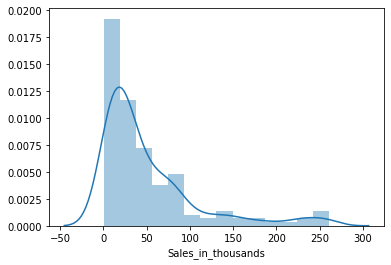

In [33]:
# Very first assumtion is that all the variables should be normally distributed, however that can't be possible
# However we have to be atleast strict about the dependant Y variable

# Distribution of variables
sns.distplot(cars_new.Sales_in_thousands)
plt.show()
# this distribution is highly skewed

# Notes:
#-----------------------------------------------------
# 1. if we get skewed data, then we have to transform the data and there are multiple methods to go about it
# 2. most commonly used and which works on most of the data is log transformation
# 3. Ideally we can do this for each of the dependant variable as well, 
#    however it will depend on amount of data and the amount of analytical rigour
# 4. In no case we can proceed if dependant variable is not normal/near to normal distributed

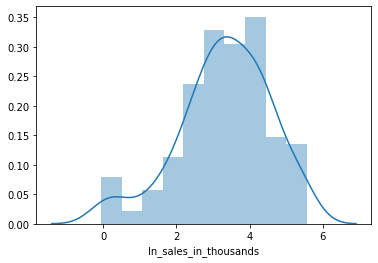

In [34]:
# Note: good practice is to take the log of the data plus 1, bcoz we don't have log of zero defined
# In thios data its not required as sales are always greater than zero

# apply log transformation: log is rescalling the data and making the distribution normal
cars_new['ln_sales_in_thousands'] = np.log(cars_new['Sales_in_thousands'])

# Distribution of variables
sns.distplot(cars_new.ln_sales_in_thousands)
plt.show()

In [35]:
# Linearity: correlation matrix (ranges from 1 to -1)
corrm = cars_new.corr()
corrm.to_excel('corrm.xlsx')

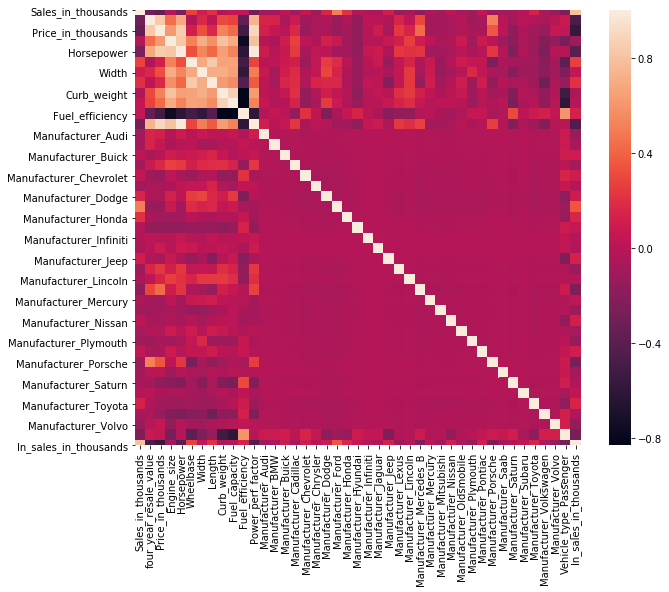

In [36]:
# visualize correlation matrix in Seaborn using a heatmap
plt.figure(figsize = (10, 8))
sns.heatmap(cars_new.corr())

# fuel efficiency vs fuel capacity
# Curb weight vs Engine Size

# in case we can't make any concrete decision looking at the variables; we can also check on the VAR of 
# the variables into consideration e.g Curb weight vs Wheel base

In [37]:
# no of variables and obs in the final data to be used for modelling
cars_new.shape

(157, 43)

In [38]:
cars_new.columns

Index(['Sales_in_thousands', 'four_year_resale_value', 'Price_in_thousands',
       'Engine_size', 'Horsepower', 'Wheelbase', 'Width', 'Length',
       'Curb_weight', 'Fuel_capacity', 'Fuel_efficiency', 'Power_perf_factor',
       'Manufacturer_Audi', 'Manufacturer_BMW', 'Manufacturer_Buick',
       'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes_B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Oldsmobile',
       'Manufacturer_Plymouth', 'Manufacturer_Pontiac', 'Manufacturer_Porsche',
       'Manufacturer_Saab', 'Manufacturer_Saturn', 'Manufacturer_Subaru',
       'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo',
       'Vehicle_

### Split the data for model building

In [40]:
# splitting the data: separate out the feature/input/independant columns and dependant variable
feature_columns = cars_new.columns.difference(['ln_sales_in_thousands', 'Sales_in_thousands'])

In [41]:
# method 1: divide the data into training and testing and separate out Y and X variables
# this will be used in sklearn related functions
train_X, test_X, train_y, test_y = train_test_split(cars_new[feature_columns], 
                    cars_new['ln_sales_in_thousands'], test_size = 0.3, random_state = 5555)

In [42]:
# method 2: divide the data into training and testing
train, test = train_test_split(cars_new, test_size = 0.3, random_state = 5555)

In [43]:
# verify the no of obs in training and testing after split
print('No of obs in training: ', len(train), ' | ', 'No of obs in testing: ', len(test))

No of obs in training:  109  |  No of obs in testing:  48


In [44]:
train.Price_in_thousands.mean()

26.54571949570879

In [45]:
test.Price_in_thousands.mean()

29.106865521505384

## Form of linear regression

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$

- $y$ is the response
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for $x_1$ (the first feature)
- $\beta_n$ is the coefficient for $x_n$ (the nth feature)

The $\beta$ values are called the **model coefficients**:

- These values are estimated (or "learned") during the model fitting process using the **least squares criterion**.
- Specifically, we are find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors").
- And once we've learned these coefficients, we can use the model to predict the response.

### Building a linear regression model

### Model 0 (using only 3 variables)

In [39]:
smf.ols?

In [46]:
lm0 = smf.ols('''ln_sales_in_thousands ~ 
                    Price_in_thousands + Fuel_efficiency + 
                            Vehicle_type_Passenger''', train).fit()

In [44]:
print(lm0.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_sales_in_thousands   R-squared:                       0.288
Model:                               OLS   Adj. R-squared:                  0.267
Method:                    Least Squares   F-statistic:                     14.13
Date:                   Sun, 30 Aug 2020   Prob (F-statistic):           8.35e-08
Time:                           13:01:57   Log-Likelihood:                -149.60
No. Observations:                    109   AIC:                             307.2
Df Residuals:                        105   BIC:                             318.0
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

### Model 1 - include all feature variables

In [45]:
m1_features = feature_columns.copy()
m1_features

Index(['Curb_weight', 'Engine_size', 'Fuel_capacity', 'Fuel_efficiency',
       'Horsepower', 'Length', 'Manufacturer_Audi', 'Manufacturer_BMW',
       'Manufacturer_Buick', 'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes_B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Oldsmobile',
       'Manufacturer_Plymouth', 'Manufacturer_Pontiac', 'Manufacturer_Porsche',
       'Manufacturer_Saab', 'Manufacturer_Saturn', 'Manufacturer_Subaru',
       'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo',
       'Power_perf_factor', 'Price_in_thousands', 'Vehicle_type_Passenger',
       'Wheelbase', 'Width', 'four_year_resale_value'],
      dtype

In [46]:
m1_formula = 'ln_sales_in_thousands ~ ' + ' + '.join(m1_features)

In [47]:
lm1 = smf.ols(m1_formula, train).fit()

In [48]:
print(lm1.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_sales_in_thousands   R-squared:                       0.645
Model:                               OLS   Adj. R-squared:                  0.428
Method:                    Least Squares   F-statistic:                     2.969
Date:                   Sun, 30 Aug 2020   Prob (F-statistic):           3.71e-05
Time:                           13:01:58   Log-Likelihood:                -111.64
No. Observations:                    109   AIC:                             307.3
Df Residuals:                         67   BIC:                             420.3
Df Model:                             41                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

### Feature selection based on importance using F - Regression

In [1]:
f_regression?

Object `f_regression` not found.


In [50]:
# Feature Selection based on importance
from sklearn.feature_selection import f_regression
F_values, p_values  = f_regression( train_X, train_y )

In [51]:
f_reg_results = pd.concat([pd.Series(train_X.columns, name = 'Variable'), 
                               pd.Series(F_values, name = 'F_Value'), 
                                   pd.Series(p_values, name = 'P_Value').round(5)], axis =  1)

In [52]:
sig_variables = f_reg_results.sort_values(by = 'P_Value')

In [53]:
sig_variables

,Variable,F_Value,P_Value
40,four_year_resale_value,25.752409,0.00000
36,Price_in_thousands,27.370413,0.00000
35,Power_perf_factor,12.035226,0.00075
38,Wheelbase,11.625844,0.00092
13,Manufacturer_Ford,10.477653,0.00161
37,Vehicle_type_Passenger,9.176972,0.00307
4,Horsepower,8.668314,0.00397
5,Length,4.550887,0.03519
14,Manufacturer_Honda,4.287216,0.04081
21,Manufacturer_Mercedes_B,3.585205,0.06100


### Model 2 - include only significant feature variables

In [54]:
m2_features = sig_variables.Variable[sig_variables.P_Value <= 0.25]

In [55]:
m2_features

40     four_year_resale_value
36         Price_in_thousands
35          Power_perf_factor
38                  Wheelbase
13          Manufacturer_Ford
37     Vehicle_type_Passenger
4                  Horsepower
5                      Length
14         Manufacturer_Honda
21    Manufacturer_Mercedes_B
19         Manufacturer_Lexus
9       Manufacturer_Cadillac
34         Manufacturer_Volvo
24        Manufacturer_Nissan
25    Manufacturer_Oldsmobile
32        Manufacturer_Toyota
23    Manufacturer_Mitsubishi
29          Manufacturer_Saab
3             Fuel_efficiency
Name: Variable, dtype: object

In [56]:
m2_formula = 'ln_sales_in_thousands ~ ' + ' + '.join(m2_features)

In [57]:
lm2 = smf.ols(m2_formula, train).fit()

In [58]:
print(lm2.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_sales_in_thousands   R-squared:                       0.569
Model:                               OLS   Adj. R-squared:                  0.476
Method:                    Least Squares   F-statistic:                     6.172
Date:                   Sun, 30 Aug 2020   Prob (F-statistic):           1.10e-09
Time:                           13:02:03   Log-Likelihood:                -122.28
No. Observations:                    109   AIC:                             284.6
Df Residuals:                         89   BIC:                             338.4
Df Model:                             19                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

###  VIF (Variance Inflation Factor): Check the multicollinieirity for all the variables in the model

In [59]:
m2_formula

'ln_sales_in_thousands ~ four_year_resale_value + Price_in_thousands + Power_perf_factor + Wheelbase + Manufacturer_Ford + Vehicle_type_Passenger + Horsepower + Length + Manufacturer_Honda + Manufacturer_Mercedes_B + Manufacturer_Lexus + Manufacturer_Cadillac + Manufacturer_Volvo + Manufacturer_Nissan + Manufacturer_Oldsmobile + Manufacturer_Toyota + Manufacturer_Mitsubishi + Manufacturer_Saab + Fuel_efficiency'

In [60]:
m2_formula = '''ln_sales_in_thousands ~ 
    Price_in_thousands + 
    Manufacturer_Ford + Vehicle_type_Passenger + 
    Length + Manufacturer_Honda + Manufacturer_Mercedes_B + Manufacturer_Lexus + 
    Manufacturer_Cadillac + Manufacturer_Volvo + Manufacturer_Nissan + 
    Manufacturer_Oldsmobile + Manufacturer_Toyota + Manufacturer_Mitsubishi +
    Manufacturer_Saab + Fuel_efficiency'''

In [61]:
# High VIF of the variable means information in that variable has already been explained by 
# other X variables present in the model

# import the packages for vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# separate the Y and X variables
y, X = dmatrices(m2_formula, train, return_type = 'dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# display the output
vif_features = vif.round(1).sort_values('VIF Factor', ascending = False)
vif_features

,Features,VIF Factor
0,Intercept,731.7
15,Fuel_efficiency,4.5
1,Price_in_thousands,3.3
3,Vehicle_type_Passenger,2.6
6,Manufacturer_Mercedes_B,1.7
4,Length,1.6
7,Manufacturer_Lexus,1.2
12,Manufacturer_Toyota,1.2
2,Manufacturer_Ford,1.1
5,Manufacturer_Honda,1.1


### Model 3 - after removal of multicolinear feature variables

In [62]:
m3_features = vif_features.Features[vif_features.Features != 'Intercept']

In [63]:
m3_features

15            Fuel_efficiency
1          Price_in_thousands
3      Vehicle_type_Passenger
6     Manufacturer_Mercedes_B
4                      Length
7          Manufacturer_Lexus
12        Manufacturer_Toyota
2           Manufacturer_Ford
5          Manufacturer_Honda
8       Manufacturer_Cadillac
10        Manufacturer_Nissan
11    Manufacturer_Oldsmobile
13    Manufacturer_Mitsubishi
9          Manufacturer_Volvo
14          Manufacturer_Saab
Name: Features, dtype: object

In [64]:
m3_formula = 'ln_sales_in_thousands ~ ' + ' + '.join(m3_features)

In [65]:
m3_formula = '''ln_sales_in_thousands ~ Fuel_efficiency + Price_in_thousands + 
        Vehicle_type_Passenger + Length + 
        Manufacturer_Ford + 
        Manufacturer_Oldsmobile'''

In [66]:
lm3 = smf.ols(m3_formula, train).fit()

In [67]:
print(lm3.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_sales_in_thousands   R-squared:                       0.478
Model:                               OLS   Adj. R-squared:                  0.447
Method:                    Least Squares   F-statistic:                     15.55
Date:                   Sun, 30 Aug 2020   Prob (F-statistic):           1.34e-12
Time:                           13:02:04   Log-Likelihood:                -132.68
No. Observations:                    109   AIC:                             279.4
Df Residuals:                        102   BIC:                             298.2
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [68]:
#After manual feature selection
m3_formula = '''ln_sales_in_thousands ~ Fuel_efficiency + Price_in_thousands + 
        Vehicle_type_Passenger + Length + 
        Manufacturer_Ford + 
        Manufacturer_Oldsmobile'''

In [69]:
lm3 = smf.ols(m3_formula, train).fit()

In [70]:
print(lm3.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_sales_in_thousands   R-squared:                       0.478
Model:                               OLS   Adj. R-squared:                  0.447
Method:                    Least Squares   F-statistic:                     15.55
Date:                   Sun, 30 Aug 2020   Prob (F-statistic):           1.34e-12
Time:                           13:02:05   Log-Likelihood:                -132.68
No. Observations:                    109   AIC:                             279.4
Df Residuals:                        102   BIC:                             298.2
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

### Model 4 - manual feature selection

In [71]:
print(list(m3_features))

['Fuel_efficiency', 'Price_in_thousands', 'Vehicle_type_Passenger', 'Manufacturer_Mercedes_B', 'Length', 'Manufacturer_Lexus', 'Manufacturer_Toyota', 'Manufacturer_Ford', 'Manufacturer_Honda', 'Manufacturer_Cadillac', 'Manufacturer_Nissan', 'Manufacturer_Oldsmobile', 'Manufacturer_Mitsubishi', 'Manufacturer_Volvo', 'Manufacturer_Saab']


In [72]:
m4_features = ['Fuel_efficiency', 'Price_in_thousands', 'Manufacturer_Oldsmobile',
                   'Vehicle_type_Passenger', 'Length', 'Manufacturer_Ford']

In [73]:
m4_formula = 'ln_sales_in_thousands ~ ' + ' + '.join(m4_features)

In [74]:
lm4 = smf.ols(m4_formula, train).fit()

In [75]:
print(lm4.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_sales_in_thousands   R-squared:                       0.478
Model:                               OLS   Adj. R-squared:                  0.447
Method:                    Least Squares   F-statistic:                     15.55
Date:                   Sun, 30 Aug 2020   Prob (F-statistic):           1.34e-12
Time:                           13:02:06   Log-Likelihood:                -132.68
No. Observations:                    109   AIC:                             279.4
Df Residuals:                        102   BIC:                             298.2
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

### Further steps

In [76]:
# Step 4: predict the sales on the training data
train['pred_sales'] = np.exp(lm4.predict(train))

C:\Users\RAHUL CHHIKARA\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [77]:
# Step 5: predict the sales on the testing/validation data
test['pred_sales'] = np.exp(lm4.predict(test))

C:\Users\RAHUL CHHIKARA\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [78]:
# Step 6: accuracy metrics (a. MAPE: Mean Absolute Percentage Error)
MAPE_train = np.mean(np.abs(train['Sales_in_thousands'] - train['pred_sales'])/train['Sales_in_thousands'])
MAPE_test = np.mean(np.abs(test['Sales_in_thousands'] - test['pred_sales'])/test['Sales_in_thousands'])

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  0.879336967666925  |  MAPE of testing data:  1.2584767656409237


In [79]:
train[['Sales_in_thousands', 'pred_sales']]

,Sales_in_thousands,pred_sales
1,39.38400,28.169002
53,155.78700,234.040918
133,49.98900,53.979615
87,26.52900,55.919360
83,0.93728,12.209274
...,...,...
59,73.20300,60.835587
115,5.24000,40.480722
29,32.77500,27.630379
12,27.85100,35.551443


In [80]:
# Step 6: accuracy metrics (b. RMSE: Root Mean Squared Error)
RMSE_train = np.sqrt(mean_squared_error(train.Sales_in_thousands ,train.pred_sales)).round(3)
RMSE_test = np.sqrt(mean_squared_error(test.Sales_in_thousands ,test.pred_sales)).round(3)

# print the values of RMSE for train and test
print('RMSE of training data: ', RMSE_train,  ' | ', 'RMSE of testing data: ', RMSE_test)

RMSE of training data:  45.449  |  RMSE of testing data:  52.407


In [81]:
# Step 6: accuracy metrics (c. Correlation)
Corr_train = stats.stats.pearsonr(train.Sales_in_thousands, train.pred_sales)
Corr_test = stats.stats.pearsonr(train.Sales_in_thousands, train.pred_sales)

# print the values of Correlation for train and test
print('Correlation of training data: ', Corr_train,  ' | ', 'Correlation of testing data: ', Corr_test)

Correlation of training data:  (0.6132075852566619, 1.3606400929498538e-12)  |  Correlation of testing data:  (0.6132075852566619, 1.3606400929498538e-12)


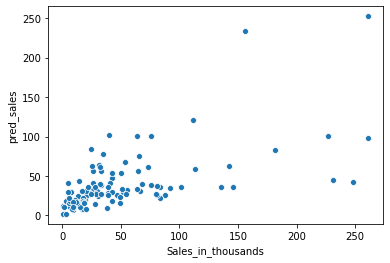

In [82]:
sns.scatterplot(train.Sales_in_thousands, train.pred_sales)

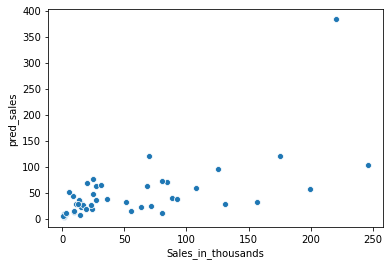

In [83]:
sns.scatterplot(test.Sales_in_thousands, test.pred_sales)

In [84]:
# Step 6: accuracy metrics (d. Decile Analysis: for validation of models - Business validation)

# create the 10 groups in the data
train['Deciles'] = pd.qcut(train['pred_sales'], 10, labels = False)
test['Deciles'] = pd.qcut(test['pred_sales'], 10, labels = False)

# Decile Analysis for train data
Predicted_avg = train[['Deciles', 'pred_sales']].groupby(train.Deciles).mean().sort_index(ascending = False)['pred_sales']
Actual_avg = train[['Deciles', 'Sales_in_thousands']].groupby(train.Deciles).mean().sort_index(ascending = False)['Sales_in_thousands']
Decile_analysis_train = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# Decile Analysis for test data
Predicted_avg = test[['Deciles', 'pred_sales']].groupby(test.Deciles).mean().sort_index(ascending = False)['pred_sales']
Actual_avg = test[['Deciles', 'Sales_in_thousands']].groupby(test.Deciles).mean().sort_index(ascending = False)['Sales_in_thousands']
Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# write the data into the file
Decile_analysis_train.to_csv('Decile_analysis_train.csv')
Decile_analysis_test.to_csv('Decile_analysis_test.csv')

C:\Users\RAHUL CHHIKARA\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\RAHUL CHHIKARA\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [85]:
Decile_analysis_test

,Deciles,pred_sales,Sales_in_thousands
0,9,164.514610,167.54000
1,8,70.731184,48.15620
2,7,58.412606,81.72440
3,6,42.127071,39.26850
4,5,34.435706,39.75740
5,4,28.565319,67.05080
6,3,23.894466,41.76975
7,2,15.472113,23.47960
8,1,9.685960,17.99760
9,0,4.560729,4.13240


### Validate the poor model performance due of LM assumptions

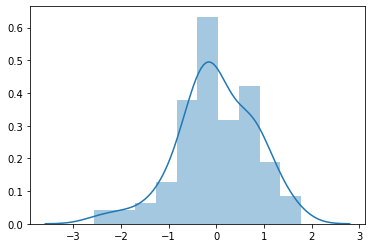

In [86]:
# assumption: Normality of the residuals/error (using distplot)
sns.distplot(lm4.resid)
plt.show()

In [87]:
# assumption: mean of residuals/errors is zero
print(lm4.resid.mean())

2.2224831557175152e-14


In [88]:
# assumption: residuals/errors of the model should not be correlated with dependant (Y) variable i.e. Autocorrelation : follows no trend
print(stats.stats.pearsonr(lm4.resid, train.ln_sales_in_thousands))

(0.7226688966760759, 7.260093891187835e-19)


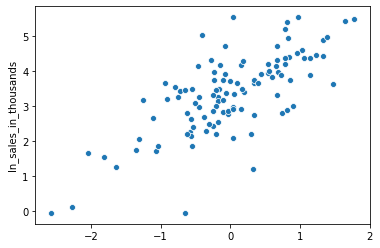

In [89]:
# assumption: homoscedasticity of residuals/errors
sns.scatterplot(lm4.resid, train.ln_sales_in_thousands)
plt.show()

### What can be the possible reasons for poor model performance?

### Tips/guidlines for imporvement of model accuracy

### Other Reading information

### Feature selection

How do we choose which features to include in the model? We're going to use **train/test split** (and eventually **cross-validation**).

Why not use of **p-values** or **R-squared** for feature selection?

- Linear models rely upon **a lot of assumptions** (such as the features being independent), and if those assumptions are violated, p-values and R-squared are less reliable. Train/test split relies on fewer assumptions.
- Features that are unrelated to the response can still have **significant p-values**.
- Adding features to your model that are unrelated to the response will always **increase the R-squared value**, and adjusted R-squared does not sufficiently account for this.
- p-values and R-squared are **proxies** for our goal of generalization, whereas train/test split and cross-validation attempt to **directly estimate** how well the model will generalize to out-of-sample data.

More generally:

- There are different methodologies that can be used for solving any given data science problem, and this course follows a **machine learning methodology**.
- This course focuses on **general purpose approaches** that can be applied to any model, rather than model-specific approaches.

### Evaluating Model Accuracy
> R-squared is a statistical measure of how close the data are to the fitted regression line. <br>
> R-square signifies percentage of variations in the reponse variable that can be explained by the model. <br>
> - R-squared = Explained variation / Total variation <br>
> - Total variation is variation of response variable around it's mean. <br>

> R-squared value varies between 0 and 100%. 0% signifies that the model explains none of the variability, <br>
while 100% signifies that the model explains all the variability of the response. <br>
The closer the r-square to 100%, the better is the model. <br>

## Other Evaluation metrics for regression problems

Evaluation metrics for classification problems, such as **accuracy**, are not useful for regression problems. We need evaluation metrics designed for comparing **continuous values**.

Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

## Comparing linear regression with other models

Advantages of linear regression:

- Simple to explain
- Highly interpretable
- Model training and prediction are fast
- No tuning is required (excluding regularization)
- Features don't need scaling
- Can perform well with a small number of observations
- Well-understood

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response
- Performance is (generally) not competitive with the best supervised learning methods due to high bias
- Can't automatically learn feature interactions